In [17]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### SALES DATASET PREPARATION

In [ ]:
# find corretations between the features and target
corr_matrix = training_data.corr()
corr_matrix["SELL_PRICE"].sort_values(ascending=False)

# filter the nth most correlated features into a features list
cond1 = ( abs(corr_matrix['SELL_PRICE']) > 0.3 )    # include greater than 0.2 correlation 
cond2 = ( abs(corr_matrix['SELL_PRICE']) < 1 )      # exclude SELL_PRICE (corr = 1)
filterinfDataframe = corr_matrix["SELL_PRICE"][cond1 & cond2]

filterinfDataframe = filterinfDataframe.nlargest(n=30)
features = filterinfDataframe.index.tolist()
features

In [14]:
# LOAD SALES DATASET

# define the dataset
training_data = pd.read_csv('..\\data\\clean-sales-data.csv', index_col='ADDRESS')
training_data = training_data.select_dtypes(include=[np.number])

# drop data columns
#training_data = training_data.drop(training_data.loc[:, 'shp__area':'bs_ave'], axis=1)
training_data = training_data.dropna(axis=0)

del training_data['LIST_PRICE']
del training_data['DOM']

features = [
    'TAX_AMT',
    'SIZE_SQFT',
    'median_val',
    'ave_val',
    'bach_pct',
    'LOT_DPTH',
    'mast_pct',
    'school_sco',
    'ave_inc',
    'BDRMS',
    'doct',
    'mast',
    'pop_chng_p',
    'doct_pct',
    'rnt_30pls',
    'bach',
    'LON',
    'mvrs_3yr_p',
    'rent_av',
    's_d_h_pct',
    'trees_km',
    'bark_km'
    ]

X = training_data[features]

# define X and y
X = training_data.loc[:, training_data.columns != 'SELL_PRICE']  #all columns except 'SELL_PRICE'
y = training_data.SELL_PRICE   #target column i.e. price range

print(f"Dataset upload complete. Dataset comprises {len(X)} entries.")

# split dataset into validation and training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

print(f"Dataset split into {len(X_train)} training data points and {len(X_val)} validation points.")

Dataset upload complete. Dataset comprises 137 entries.
Dataset split into 123 training data points and 14 validation points.


### PROPERTIES DATASET PREPARATION

In [42]:
# LOAD PROPERTIES DATASET
 
# define the dataset
training_data = pd.read_csv('..\\data\\train.csv', index_col='ADDRESS')
training_data = training_data.select_dtypes(include=[np.number])

# define X and y
X = training_data.loc[:, training_data.columns != 'SELL_PRICE']
y = training_data.SELL_PRICE   #target column i.e. price range

print(f"Dataset upload complete. Dataset comprises {len(X)} entries.")

# split dataset into validation and training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

print(f"Dataset split into {len(X_train)} training data points and {len(X_val)} validation points.")

Dataset upload complete. Dataset comprises 464 entries.
Dataset split into 417 training data points and 47 validation points.


### MODEL EVALUATION

In [33]:
# define models to evaluate
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    #'linearregression_model': LinearRegression(),
    #'elasticnet_model': ElasticNet(alpha = 0.1, random_state = 1),
    #'lasso_model': Lasso(alpha = 0.1, random_state = 1),
    #'dtr_model': DecisionTreeRegressor(random_state=1),
    'dtr_mln_training_model': DecisionTreeRegressor(max_leaf_nodes=100, random_state=1),
    'rf_model': RandomForestRegressor(criterion='absolute_error', random_state=1),
    'gbr_model': GradientBoostingRegressor(random_state=1), 
    'XGBR_model': XGBRegressor(n_estimators=1000, learning_rate=0.05)
    }

In [34]:
# function for comparing different approaches
def score_models(model, X_train, X_val, y_train, y_val):
    # specify training model
    training_model = model
    # fit training model
    training_model.fit(X_train, y_train)
    # make validation predictions on the validation data
    validation_predictions = training_model.predict(X_val)
    # calculate mean absolute error on the validation data
    validation_mae = mean_absolute_error(validation_predictions, y_val)
    # calculate model score
    model_score = training_model.score(X_val, y_val)
    return validation_mae, model_score

def score_models_k_folds(model, X, y,):
    k_folds_scores = -1 * cross_val_score(model, X, y,
                                cv=10,               
                                scoring='neg_mean_absolute_error')
    mean_k_folds_score = k_folds_scores.mean()
    return mean_k_folds_score

# create pandas DataFrame to store model evaluation results
df_model_scores = pd.DataFrame({'model':[],
                                'CoD':[],
                                'MAE':[],
                                'k-folds_MAE':[]})


for model_key in models:
    model = models[model_key]
    validation_mae, model_score = score_models(model, X_train, X_val, y_train, y_val)
    mean_k_folds_score = score_models_k_folds(model, X, y)

    # create pandas Series object with all the column values passed as a Python list
    s_row = pd.Series([model_key, 
                        model_score, 
                        validation_mae, 
                        mean_k_folds_score], 
                        index=df_model_scores.columns)
 
    # append pandas Series object as a row to the existing pandas DataFrame
    df_model_scores = df_model_scores.append(s_row,ignore_index=True)


In [35]:
df_model_scores.sort_values('MAE')

,model,CoD,MAE,k-folds_MAE
1,rf_model,0.210622,160087.058298,148768.403814
3,XGBR_model,0.218486,161528.219415,149665.533418
2,gbr_model,0.176361,168782.460462,150840.750403
0,dtr_mln_training_model,-0.414000,193156.719545,216439.346656


In [46]:
# RANDOM FOREST REGRESSOR 
from sklearn.ensemble import RandomForestRegressor

# specify training model
rf_training_model = RandomForestRegressor(n_estimators=500, 
                        criterion='absolute_error', 
                        random_state=0)
# fit training model
rf_training_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = rf_training_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", rf_training_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.2258032819389808
MAE is: 
 158466.58474468088


Text(0.5, 1.0, 'Random Forest Regression')

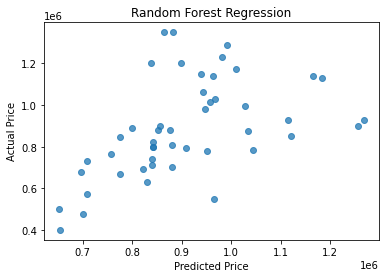

In [47]:
import matplotlib.pyplot as plt

predictions = rf_training_model.predict(X_val)
actual_values = y_val

plt.scatter(predictions, actual_values, alpha=.75) #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Regression')

In [44]:
# DECISION TREE REGRESSOR 
from sklearn.tree import DecisionTreeRegressor

# specify training model
dtr_mln_training_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
# fit training model
dtr_mln_training_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = dtr_mln_training_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", dtr_mln_training_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.8920477906014216
MAE is: 
 52383.333333333336


In [25]:
# GRADIENT BOOSTING REGRESSOR 
from sklearn.ensemble import GradientBoostingRegressor

# specify training model
gbr_model = GradientBoostingRegressor(random_state=1)
# fit training model
gbr_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = gbr_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", gbr_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.1763609493594943
MAE is: 
 168782.4604623586


Text(0.5, 1.0, 'GradientBoostingRegressor Model')

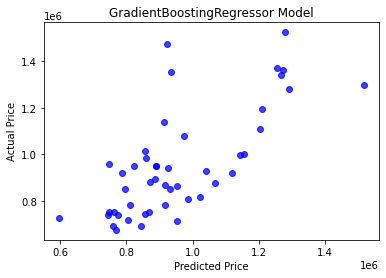

In [150]:
import matplotlib.pyplot as plt

predictions = gbr_model.predict(X_val)
actual_values = y_val

plt.scatter(predictions, actual_values, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('GradientBoostingRegressor Model')

In [7]:
# XGBOOST
from xgboost import XGBRegressor

XGBR_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
XGBR_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)],
             verbose=False)

predictions = XGBR_model.predict(X_val)

print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_val)))

Mean Absolute Error: 127133.55585106384


In [137]:
# ELASTIC-NET 
from sklearn.linear_model import ElasticNet

# specify training model
en_model = ElasticNet(alpha = 0.1, random_state = 1)
# fit training model
en_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = en_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", en_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.31784507380195826
MAE is: 
 132267.43803760855


C:\Users\Shane\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.673e+12, tolerance: 2.461e+09
  model = cd_fast.enet_coordinate_descent(


In [138]:
# LASSO
from sklearn.linear_model import Lasso

# specify training model
lasso_model = Lasso(alpha = 0.1, random_state = 1)
# fit training model
lasso_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = lasso_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", lasso_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.3125024216034511
MAE is: 
 135947.23713193042


C:\Users\Shane\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.642e+12, tolerance: 2.461e+09
  model = cd_fast.enet_coordinate_descent(


In [154]:
# LINEAR REGRESSION
from sklearn.linear_model import LinearRegression

# specify training model
lr_model = LinearRegression()
# fit training model
lr_model.fit(X_train, y_train)
# make validation predictions on the validation data
validation_predictions = lr_model.predict(X_val)
# calculate mean absolute error on the validation data
validation_mae = mean_absolute_error(validation_predictions, y_val)

print ("R^2 is: \n", lr_model.score(X_val, y_val))
print ("MAE is: \n", validation_mae)

R^2 is: 
 0.29099446258399886
MAE is: 
 139095.1180729156


### === END OF WORKING CODE ===